#**Imports**

In [1]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from torchvision.transforms.functional import to_pil_image
from torchvision import models, transforms

from fastai.callbacks import hook_outputs
from fastai.torch_core import requires_grad, children

In [2]:
torch.backends.cudnn.deterministic = True 
# check if training using GPU is possible
torch.cuda.is_available()

True

In [3]:
# mounting Google Drive with your credentials 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# folder, created in advance in the Google Drive and containing kaggle.json
#project_folder = "/content/gdrive/My Drive/Kaggle/NaturalPainters" # for original email
project_folder = "/content/gdrive/MyDrive/NaturalPainters" 
os.environ['KAGGLE_CONFIG_DIR'] = project_folder

In [5]:
# dive into folder
#%cd /content/gdrive/MyDrive/Kaggle/NaturalPainters
%cd /content/gdrive/MyDrive/NaturalPainters

/content/gdrive/.shortcut-targets-by-id/1m2LH2VheZ1KLU1PiFqOKItm5-sBWZ1C4/NaturalPainters


In [6]:
# path to load the generator weights
generator_path = project_folder + '/models/generator/generator_5152w_10e_1d.pth'
# path to load the discriminator weights
discriminator_path = project_folder + '/models/discriminator/discriminator_10e.pth'
# path to save GAN generator and discriminator
gan_path = project_folder + '/models/gan/'
# path to save progress of generated strokes
gen_strokes_path = project_folder + '/generated_strokes/gan/'
# path to save gan loss
plots_path = project_folder + '/plots/'

In [7]:
SEED = 4

In [8]:
# data is stored in the 'episodes_i.npz' format, where i is in {0,...,77}
# this routine loads desired 'episodes_i.npz' for a particular i
# data will be loaded in the dictionary with two fields: 'strokes' and 'actions'
def load_data(npz):

    data = np.load('strokes-dataset/' + npz)
    return data['strokes'], data['actions']

# **Generator**

In [9]:
class Generator(nn.Module):

    def __init__(self, 
                 in_features: int,
                 img_height: int,
                 img_width: int,
                 num_features: int,
                 img_channels: int):
      super(Generator, self).__init__()

      self.out_features = img_height * img_width

      self.lin = nn.Linear(in_features, self.out_features)

      self.conv1 = nn.ConvTranspose2d(self.out_features, num_features, 
                                      kernel_size = (4, 4), stride = (1, 1), bias = False)
      self.norm1 = nn.BatchNorm2d(num_features)

      self.conv2 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm2 = nn.BatchNorm2d(num_features)

      self.conv3 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm3 = nn.BatchNorm2d(num_features)

      self.conv4 = nn.ConvTranspose2d(num_features, num_features//2, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
      num_features //= 2
      self.norm4 = nn.BatchNorm2d(num_features)

      self.conv5 = nn.ConvTranspose2d(num_features, num_features, 
                                      kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), bias = False)
      self.norm5 = nn.BatchNorm2d(num_features)

      self.conv6 = nn.ConvTranspose2d(num_features, img_channels, 
                                      kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)



    def forward(self, x):
      x = self.lin(x)
      x = F.relu(self.conv1(x.view(x.size(0), x.size(1), 1, 1)), inplace = True)
      x = self.norm1(x)
      x = F.relu(self.conv2(x), inplace = True)
      x = self.norm2(x)
      x = F.relu(self.conv3(x), inplace = True)
      x = self.norm3(x)
      x = F.relu(self.conv4(x), inplace = True)
      x = self.norm4(x)
      x = F.relu(self.conv5(x), inplace = True)
      x = self.norm5(x)

      return torch.tanh(self.conv6(x))

In [10]:
class FeatureExtractor(nn.Module):

    def __init__(self, 
                 layers_weights,
                 device):
      super(FeatureExtractor, self).__init__()
      
      self.layers_weights = layers_weights
      self.device = device
      self.feature_extractor, self.layers_indices = self.extractor()
      self.outputs = hook_outputs([self.feature_extractor[i] for i in self.layers_indices], detach = False)

    def extractor(self):
        print("Download VGG19 (batch normalized) as pre-trained.\n")
        if self.device == 'cuda':
            extractor = models.vgg19_bn(True).features.cuda().eval()
        else:
            extractor = models.vgg19_bn(True).features.eval()
        requires_grad(extractor, False)
        return extractor, [i - 1 for i, layer in enumerate(children(extractor)) if isinstance(layer, nn.MaxPool2d)][2:]

    def gram_matrix(self, input):

        (a, b, c, d) = input.size()
        features = input.view(a, b, c * d)
        G = features @ features.transpose(1, 2)
        return G.div(b * c * d)

    def forward(self, gen_stroke, true_stroke):

        self.feature_extractor(gen_stroke)
        gen_stroke_features = [out for out in self.outputs.stored]
        
        self.feature_extractor(true_stroke)
        true_stroke_features = [out.clone() for out in self.outputs.stored]

        self.loss = []
        
        feature_loss = [F.l1_loss(gen_layer, true_layer) * weight
                             for gen_layer, true_layer, weight 
                        in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]
        

        style_loss = [F.l1_loss(self.gram_matrix(gen_layer), self.gram_matrix(true_layer)) * weight**2 * 5000
                             for gen_layer, true_layer, weight 
                      in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]
    
        pixel_loss = [F.l1_loss(gen_stroke, true_stroke)]

        self.loss += feature_loss + style_loss + pixel_loss
                
        return sum(self.loss)

    def __del__(self):
        self.outputs.remove()

# **Discriminator**

In [11]:
class Discriminator(nn.Module):
  def __init__(self, 
               img_channels: int, 
               num_features: int):
    super(Discriminator, self).__init__()

    self.conv1 = nn.Conv2d(img_channels, num_features, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    self.conv2 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    num_features *= 2
    self.norm2 = nn.BatchNorm2d(num_features)
    self.conv3 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    num_features *= 2
    self.norm3 = nn.BatchNorm2d(num_features)
    self.conv4 = nn.Conv2d(num_features, num_features*2, kernel_size = (4, 4), stride = (2, 2), padding = (1, 1))
    self.norm4 = nn.BatchNorm2d(num_features*2)
    self.lin = nn.Linear(4*4*(num_features*2), 1)


  def forward(self, x):
    x = F.leaky_relu(self.conv1(x), negative_slope = 0.2)
    x = F.leaky_relu(self.norm2(self.conv2(x)), negative_slope = 0.2)
    x = F.leaky_relu(self.norm3(self.conv3(x)), negative_slope = 0.2)
    x = F.leaky_relu(self.norm4(self.conv4(x)), negative_slope = 0.2)
    x = x.flatten(start_dim = 1)

    return self.lin(x)

#**Training**

In [12]:
class Trainer():

    def __init__(self,
                 transforms,
                 generator: nn.Module,
                 feature_extractor: nn.Module,
                 discriminator: nn.Module,
                 g_optimizer: torch.optim,
                 d_optimizer: torch.optim,
                 loss: torch.nn.functional,
                 epochs: int = 5,
                 gpu: bool = False):
            super(Trainer, self).__init__()

            self.transforms = transforms
            self.generator = generator
            self.feature_extractor = feature_extractor
            self.discriminator = discriminator
            self.g_optimizer = g_optimizer
            self.d_optimizer = d_optimizer
            self.loss = loss
            self.epochs = epochs
            self.gpu = gpu

    def train(self,
              dataloader,
              print_interval: int = 50,
              save_img_path: str = '',
              save_model_path: str = '',
              verbose: bool = True):

        d_train_loss = []
        g_train_loss = []
        mean_d_train_loss = []
        mean_g_train_loss = []
        train_gen_strokes = torch.ones_like(dataloader.sampler.data_source.tensors[0][0], dtype = torch.float32)

        print('-'*100)
        print('START OF TRAINING\n')
        for epoch in range(self.epochs):
            
            self.generator.train()
            self.discriminator.train()

            epoch_gen_strokes = torch.ones_like(dataloader.sampler.data_source.tensors[0][0], dtype = torch.float32)
          
            epoch_start_time = time.time()

            for i, (stroke, action) in enumerate(dataloader):  

                stroke = torch.stack([self.transforms(s) for s in stroke])
                
                y_true = torch.ones((stroke.shape[0], 1), dtype = torch.float, requires_grad = False)   
                y_gen = torch.zeros((stroke.shape[0], 1), dtype = torch.float, requires_grad = False)

                if gpu:
                  action = action.cuda()
                  stroke = stroke.cuda()
                  y_true = y_true.cuda()
                  y_gen = y_gen.cuda()

                # Discriminator part

                self.d_optimizer.zero_grad()

                y_true_pred = torch.sigmoid(self.discriminator(stroke))
                true_loss = self.loss(y_true_pred, y_true)

                gen_stroke = self.generator(action)
                d_y_gen_pred = torch.sigmoid(self.discriminator(gen_stroke))
                gen_loss = self.loss(d_y_gen_pred, y_gen)

                d_cur_loss = 0.5 * true_loss + 0.5 * gen_loss

                d_cur_loss.backward()
                self.d_optimizer.step()

                d_train_loss.append(d_cur_loss.data.item())
                mean_d_train_loss.append(torch.mean(torch.FloatTensor(d_train_loss)))

                # Generator part

                self.g_optimizer.zero_grad()

                gen_stroke = self.generator(action)
                g_y_gen_pred = torch.sigmoid(self.discriminator(gen_stroke))

                g_cur_loss = 0.5 * self.loss(g_y_gen_pred, y_true) + 0.5 * self.feature_extractor(gen_stroke, stroke)

                g_cur_loss.backward()
                self.g_optimizer.step()

                g_train_loss.append(g_cur_loss.data.item())
                mean_g_train_loss.append(torch.mean(torch.FloatTensor(g_train_loss)))


                if ((i % print_interval) == 0) and verbose:
                    print('Epoch {}/{} | Sample {}/{}'.format((epoch + 1), self.epochs,
                                                              (i + 1), len(dataloader)))
                    
                    print(' => Loss (discriminator): {:.3f}'.format(torch.mean(torch.FloatTensor(d_train_loss))))
                    print(' => Loss (generator): {:.3f}\n'.format(torch.mean(torch.FloatTensor(g_train_loss))))
                    
                    print('true vs generated stroke:')
                    self.display_img(torch.cat((stroke[0].clone().cpu(), gen_stroke[0].clone().cpu()), dim = 2))

                    print('='*40)
                    print('true\t\tdiscriminator prediction')
                    print('-'*40)
                    print(f'{1}\t\t{round(y_true_pred[0].item(), 3)}')
                    print(f'{0}\t\t{round(g_y_gen_pred[0].item(), 3)}')
                    print('='*40)

                    print('-'*55)

                    epoch_gen_strokes = torch.cat((epoch_gen_strokes.clone().cpu(), gen_stroke[0].clone().cpu()), dim = 2)
                    if epoch == 0:
                      train_gen_strokes = torch.cat((train_gen_strokes.clone().cpu(), stroke[0].clone().cpu()), dim = 2)

            
            print('-'*100)
            epoch_time = time.time()- epoch_start_time
            print('End of epoch {}/{} - time: {:.3f}'.format((epoch + 1), self.epochs,
                                                             epoch_time))
            print(' => Loss (discriminator): {:.3f}'.format(torch.mean(torch.FloatTensor(d_train_loss))))
            print(' => Loss (generator): {:.3f}\n'.format(torch.mean(torch.FloatTensor(g_train_loss))))
            print('examples of generated during epoch strokes:')
            self.display_img(epoch_gen_strokes)
            print('-'*100)

            train_gen_strokes = torch.cat((train_gen_strokes, epoch_gen_strokes), dim = 1)        

        if save_model_path != '':
            torch.save(self.generator.state_dict(), save_model_path + f'GAN_generator_{self.epochs}e.pth')   
            torch.save(self.discriminator.state_dict(), save_model_path + f'GAN_discriminator_{self.epochs}e.pth')
            print(f'\nEND OF TRAINING: models are saved to {save_model_path}\n')
            
        print('training progress for the examples of generated strokes:')
        self.display_img(train_gen_strokes)

        if save_img_path != '':
            self.save_img(train_gen_strokes, save_img_path + f'GAN_generator_{self.epochs}e.png')

        return {
              'd_train_loss': d_train_loss,
              'g_train_loss': g_train_loss,
              'mean_d_train_loss': mean_d_train_loss,
              'mean_g_train_loss': mean_g_train_loss}

    def save_img(self, img, save_path, print_info = True):
        to_pil_image(img).save(save_path, optimize = True, subsampling = 0, quality = 100)
        if print_info:
            print(f"\nImage is saved to {save_path}.")

    def display_img(self, img):
        display(to_pil_image(img))           

Training is performed using GPU.

Download VGG19 (batch normalized) as pre-trained.



Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

----------------------------------------------------------------------------------------------------
START OF TRAINING

Epoch 1/2 | Sample 1/391
 => Loss (discriminator): 0.000
 => Loss (generator): 6.791

true vs generated stroke:


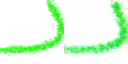

true		discriminator prediction
----------------------------------------
1		1.0
0		0.0
-------------------------------------------------------
Epoch 1/2 | Sample 26/391
 => Loss (discriminator): 0.150
 => Loss (generator): 4.150

true vs generated stroke:


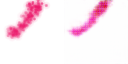

true		discriminator prediction
----------------------------------------
1		0.994
0		0.003
-------------------------------------------------------
Epoch 1/2 | Sample 51/391
 => Loss (discriminator): 0.282
 => Loss (generator): 3.320

true vs generated stroke:


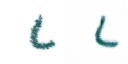

true		discriminator prediction
----------------------------------------
1		0.607
0		0.022
-------------------------------------------------------
Epoch 1/2 | Sample 76/391
 => Loss (discriminator): 0.404
 => Loss (generator): 2.776

true vs generated stroke:


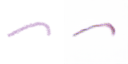

true		discriminator prediction
----------------------------------------
1		0.819
0		0.259
-------------------------------------------------------
Epoch 1/2 | Sample 101/391
 => Loss (discriminator): 0.465
 => Loss (generator): 2.463

true vs generated stroke:


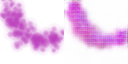

true		discriminator prediction
----------------------------------------
1		0.543
0		0.48
-------------------------------------------------------
Epoch 1/2 | Sample 126/391
 => Loss (discriminator): 0.493
 => Loss (generator): 2.269

true vs generated stroke:


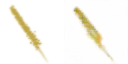

true		discriminator prediction
----------------------------------------
1		0.372
0		0.339
-------------------------------------------------------
Epoch 1/2 | Sample 151/391
 => Loss (discriminator): 0.509
 => Loss (generator): 2.145

true vs generated stroke:


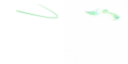

true		discriminator prediction
----------------------------------------
1		0.766
0		0.207
-------------------------------------------------------
Epoch 1/2 | Sample 176/391
 => Loss (discriminator): 0.522
 => Loss (generator): 2.052

true vs generated stroke:


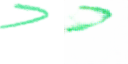

true		discriminator prediction
----------------------------------------
1		0.589
0		0.133
-------------------------------------------------------
Epoch 1/2 | Sample 201/391
 => Loss (discriminator): 0.526
 => Loss (generator): 1.988

true vs generated stroke:


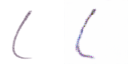

true		discriminator prediction
----------------------------------------
1		0.62
0		0.584
-------------------------------------------------------
Epoch 1/2 | Sample 226/391
 => Loss (discriminator): 0.529
 => Loss (generator): 1.947

true vs generated stroke:


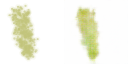

true		discriminator prediction
----------------------------------------
1		0.83
0		0.142
-------------------------------------------------------
Epoch 1/2 | Sample 251/391
 => Loss (discriminator): 0.529
 => Loss (generator): 1.909

true vs generated stroke:


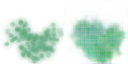

true		discriminator prediction
----------------------------------------
1		0.59
0		0.35
-------------------------------------------------------
Epoch 1/2 | Sample 276/391
 => Loss (discriminator): 0.530
 => Loss (generator): 1.881

true vs generated stroke:


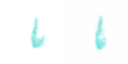

true		discriminator prediction
----------------------------------------
1		0.886
0		0.212
-------------------------------------------------------
Epoch 1/2 | Sample 301/391
 => Loss (discriminator): 0.528
 => Loss (generator): 1.860

true vs generated stroke:


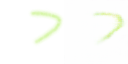

true		discriminator prediction
----------------------------------------
1		0.495
0		0.376
-------------------------------------------------------
Epoch 1/2 | Sample 326/391
 => Loss (discriminator): 0.525
 => Loss (generator): 1.847

true vs generated stroke:


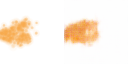

true		discriminator prediction
----------------------------------------
1		0.962
0		0.024
-------------------------------------------------------
Epoch 1/2 | Sample 351/391
 => Loss (discriminator): 0.525
 => Loss (generator): 1.833

true vs generated stroke:


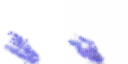

true		discriminator prediction
----------------------------------------
1		0.918
0		0.168
-------------------------------------------------------
Epoch 1/2 | Sample 376/391
 => Loss (discriminator): 0.523
 => Loss (generator): 1.825

true vs generated stroke:


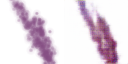

true		discriminator prediction
----------------------------------------
1		0.892
0		0.164
-------------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 1/2 - time: 578.518
 => Loss (discriminator): 0.522
 => Loss (generator): 1.818

examples of generated during epoch strokes:


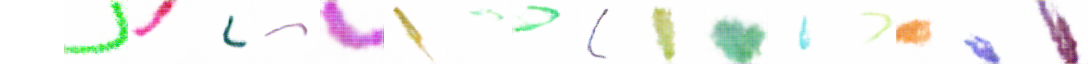

----------------------------------------------------------------------------------------------------
Epoch 2/2 | Sample 1/391
 => Loss (discriminator): 0.522
 => Loss (generator): 1.819

true vs generated stroke:


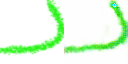

true		discriminator prediction
----------------------------------------
1		0.908
0		0.398
-------------------------------------------------------
Epoch 2/2 | Sample 26/391
 => Loss (discriminator): 0.519
 => Loss (generator): 1.812

true vs generated stroke:


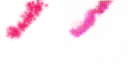

true		discriminator prediction
----------------------------------------
1		0.731
0		0.313
-------------------------------------------------------
Epoch 2/2 | Sample 51/391
 => Loss (discriminator): 0.515
 => Loss (generator): 1.808

true vs generated stroke:


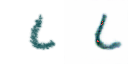

true		discriminator prediction
----------------------------------------
1		0.855
0		0.057
-------------------------------------------------------
Epoch 2/2 | Sample 76/391
 => Loss (discriminator): 0.514
 => Loss (generator): 1.803

true vs generated stroke:


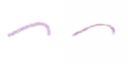

true		discriminator prediction
----------------------------------------
1		0.843
0		0.019
-------------------------------------------------------
Epoch 2/2 | Sample 101/391
 => Loss (discriminator): 0.513
 => Loss (generator): 1.801

true vs generated stroke:


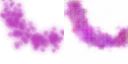

true		discriminator prediction
----------------------------------------
1		0.875
0		0.235
-------------------------------------------------------
Epoch 2/2 | Sample 126/391
 => Loss (discriminator): 0.511
 => Loss (generator): 1.797

true vs generated stroke:


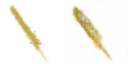

true		discriminator prediction
----------------------------------------
1		0.221
0		0.095
-------------------------------------------------------
Epoch 2/2 | Sample 151/391
 => Loss (discriminator): 0.510
 => Loss (generator): 1.796

true vs generated stroke:


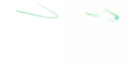

true		discriminator prediction
----------------------------------------
1		0.78
0		0.222
-------------------------------------------------------
Epoch 2/2 | Sample 176/391
 => Loss (discriminator): 0.509
 => Loss (generator): 1.793

true vs generated stroke:


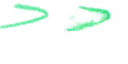

true		discriminator prediction
----------------------------------------
1		0.752
0		0.337
-------------------------------------------------------
Epoch 2/2 | Sample 201/391
 => Loss (discriminator): 0.506
 => Loss (generator): 1.791

true vs generated stroke:


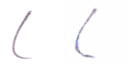

true		discriminator prediction
----------------------------------------
1		0.761
0		0.163
-------------------------------------------------------
Epoch 2/2 | Sample 226/391
 => Loss (discriminator): 0.504
 => Loss (generator): 1.790

true vs generated stroke:


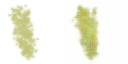

true		discriminator prediction
----------------------------------------
1		0.596
0		0.094
-------------------------------------------------------
Epoch 2/2 | Sample 251/391
 => Loss (discriminator): 0.501
 => Loss (generator): 1.790

true vs generated stroke:


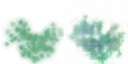

true		discriminator prediction
----------------------------------------
1		0.984
0		0.013
-------------------------------------------------------
Epoch 2/2 | Sample 276/391
 => Loss (discriminator): 0.499
 => Loss (generator): 1.792

true vs generated stroke:


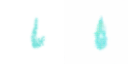

true		discriminator prediction
----------------------------------------
1		0.947
0		0.112
-------------------------------------------------------
Epoch 2/2 | Sample 301/391
 => Loss (discriminator): 0.496
 => Loss (generator): 1.794

true vs generated stroke:


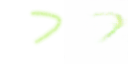

true		discriminator prediction
----------------------------------------
1		0.472
0		0.421
-------------------------------------------------------
Epoch 2/2 | Sample 326/391
 => Loss (discriminator): 0.493
 => Loss (generator): 1.796

true vs generated stroke:


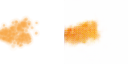

true		discriminator prediction
----------------------------------------
1		0.882
0		0.036
-------------------------------------------------------
Epoch 2/2 | Sample 351/391
 => Loss (discriminator): 0.491
 => Loss (generator): 1.798

true vs generated stroke:


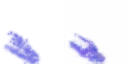

true		discriminator prediction
----------------------------------------
1		0.868
0		0.031
-------------------------------------------------------
Epoch 2/2 | Sample 376/391
 => Loss (discriminator): 0.488
 => Loss (generator): 1.800

true vs generated stroke:


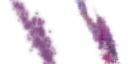

true		discriminator prediction
----------------------------------------
1		0.526
0		0.35
-------------------------------------------------------
----------------------------------------------------------------------------------------------------
End of epoch 2/2 - time: 584.722
 => Loss (discriminator): 0.487
 => Loss (generator): 1.802

examples of generated during epoch strokes:


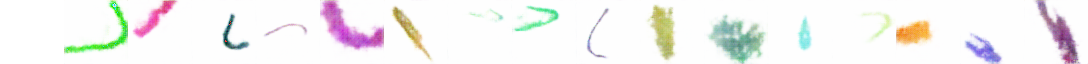

----------------------------------------------------------------------------------------------------

END OF TRAINING: models are saved to /content/gdrive/MyDrive/NaturalPainters/models/gan/

training progress for the examples of generated strokes:


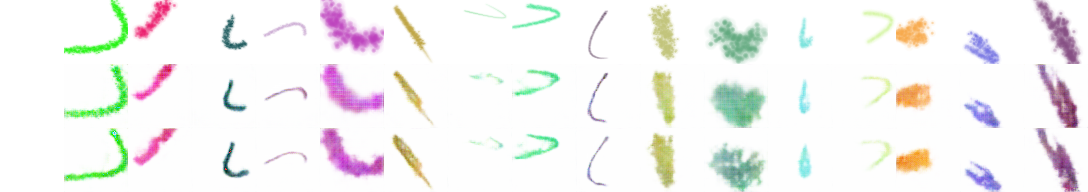


Image is saved to /content/gdrive/MyDrive/NaturalPainters/generated_strokes/gan/GAN_generator_2e.png.


In [13]:
torch.manual_seed(SEED)
class Hparams():
    in_features = 12 #constant
    num_features = 512 #@param {type:"slider", min:8, max:1024, step:8}
    img_height = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_width = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_channels = 3 #@param {type:"slider", min:1, max:3, step:2}
    layers_weights = [5, 15, 2] #@param
    batch_size = 256 #@param {type: "slider", min:8, max:512, step:8}
    lr = 0.0001 #@param {type:"number"}
    betas = (0.5, 0.9) #@param
    epochs = 2 #@param {type:"slider", min:1, max:1000, step:1}
    print_interval = 25 #@param {type:"slider", min:1, max:100, step:10}
hparams = Hparams()

current_npz = 'episodes_2.npz'

strokes, actions = load_data(current_npz)

strokes = torch.stack([torch.from_numpy(stroke).permute(2, 0, 1) for stroke in strokes])
actions = torch.stack([torch.from_numpy(action).float() for action in actions])

dataset = TensorDataset(strokes, actions)

dataloader = DataLoader(dataset, 
                        batch_size = hparams.batch_size, 
                        shuffle = False)

generator = Generator(hparams.in_features,
                      hparams.img_height,
                      hparams.img_width,
                      hparams.num_features,
                      hparams.img_channels)

discriminator = Discriminator(hparams.img_channels, 
                              hparams.img_height)

gpu = torch.cuda.is_available()
if gpu:
    print("Training is performed using GPU.\n")
    device = 'cuda'
else:
    print("Training is performed using CPU.\n")
    device = 'cpu'

feature_extractor = FeatureExtractor(hparams.layers_weights, device)

generator.load_state_dict(torch.load(generator_path, 
                                     map_location = torch.device(device)))
discriminator.load_state_dict(torch.load(discriminator_path, 
                                     map_location = torch.device(device)))

generator.to(device)
discriminator.to(device)

g_optimizer = optim.Adam(generator.parameters(), 
                       lr = hparams.lr, 
                       betas = hparams.betas)

d_optimizer = optim.Adam(discriminator.parameters(), 
                       lr = hparams.lr, 
                       betas = hparams.betas)

loss = F.binary_cross_entropy

strokes_tfms = transforms.Compose([transforms.Lambda(lambda x: 
                                                     x.float()),
                                   transforms.Lambda(lambda x: 
                                                     x.div_(255))
                                  ])

trainer = Trainer(strokes_tfms,
                  generator,
                  feature_extractor,
                  discriminator,
                  g_optimizer,
                  d_optimizer,
                  loss,
                  epochs = hparams.epochs,
                  gpu = gpu)

train_history = trainer.train(dataloader, 
              print_interval = hparams.print_interval,
              save_img_path = gen_strokes_path,
              save_model_path = gan_path)

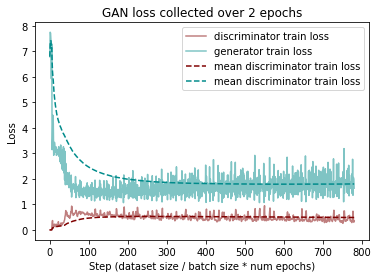

In [25]:
# plot and save train loss
fig, axs = plt.subplots()
plt.plot(train_history['d_train_loss'], '-', color = 'maroon', alpha = 0.5)
plt.plot(train_history['g_train_loss'], '-', color = 'darkcyan', alpha = 0.5)
plt.plot(train_history['mean_d_train_loss'], '--', color = 'maroon')
plt.plot(train_history['mean_g_train_loss'], '--', color = 'darkcyan')
plt.title('GAN loss collected over 2 epochs')
plt.ylabel('Loss')
plt.xlabel('Step (dataset size / batch size * num epochs)')
#plt.xlim([-1, 795])
#plt.ylim([0.2, 1])
plt.legend(['discriminator train loss', 'generator train loss', 'mean discriminator train loss', 'mean discriminator train loss'], 
           loc='upper right')
fig.savefig(plots_path + f'gan_{hparams.epochs}e_{SEED}seed.png', bbox_inches = 'tight')
plt.show()